# Sector Rotation Strategy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

list_of_sector_etfs = [
    "XLK", # SPDR Technology Sector Fund
    "XLY", # SPDR Consumer Discretionary Sector Fund
    "XLF", # SPDR Financial Sector Fund
    "XLI", # SPDR Industrial Sector Fund
    "XLV", # SPDR Health Care Sector Fund
    "XLP", # SPDR Consumer Staples Sector Fund
    "XLE", # SPDR Energy Sector Fund
    "XLB", # SPDR Materials Sector Fund
    "XLU", # SPDR Utilities Sector Fund
    "IYR", # iShares U.S. Real Estate
]

def sharpe_ratio(r):
    return np.sqrt(12) * r.mean() / r.std()

def get_return(x):
    return x*100 - 100

# download the data from yfinance API

sector_df = yf.download(" ".join(list_of_sector_etfs))['Adj Close'].dropna()
spy = yf.download("SPY")['Adj Close']

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


# Strategy Results

Here we test two different Sector Rotation strategies, one based on picking the minimum variance sector ETF and holding for one month, and another based on picking the sector ETF with the highest one year return and holding for one month. We see that both strategies out perform in terms of returns but the minimum variance strategy provides a better sharpe ratio (risk-reward ratio).

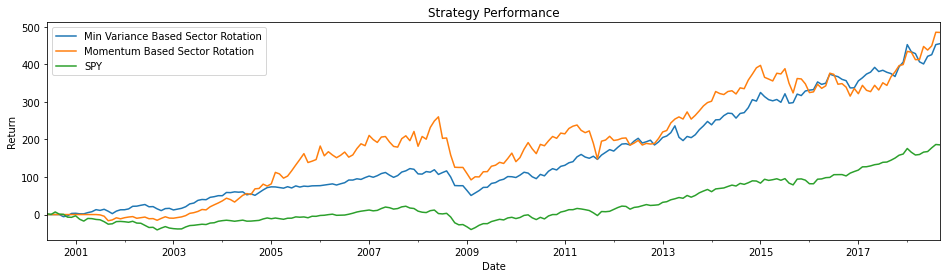

Min Variance Strategy Sharpe:  0.89
Momentum Strategy Sharpe:  0.63
SPY Sharpe:  0.47


In [3]:
min_variance_mask = (sector_df.pct_change().rolling(63).var().rank(axis=1).resample('1m').last() == 1)
min_variance_mask = (min_variance_mask.div(min_variance_mask.sum(axis=1),axis=0)).dropna()
min_variance_returns = (sector_df.resample('1m').last().pct_change()*min_variance_mask.shift()).sum(axis=1)

momentum_mask = ((-sector_df.resample('1m').last().pct_change(11)).rank(axis=1) == 1)
momentum_mask = (momentum_mask.div(momentum_mask.sum(axis=1),axis=0)).dropna()
momentum_returns = (sector_df.resample('1m').last().pct_change()*momentum_mask.shift(2)).sum(axis=1)

start_index = max(momentum_returns.index[0], min_variance_returns.index[0])

get_return((1+min_variance_returns)[start_index:].cumprod()).plot(figsize=(16,4),
                                                label='Min Variance Based Sector Rotation')
get_return((1+momentum_returns)[start_index:].cumprod()).plot(figsize=(16,4),
                                                label='Momentum Based Sector Rotation')
get_return((1+spy.resample('1m').last().pct_change()[start_index:]).cumprod()).plot(figsize=(16,4),
                                                label='SPY')
plt.title("Strategy Performance")
plt.ylabel("Return")
plt.legend()
plt.show()

print("Min Variance Strategy Sharpe: ", np.round(sharpe_ratio(min_variance_returns[start_index:]),2))
print("Momentum Strategy Sharpe: ", np.round(sharpe_ratio(momentum_returns[start_index:]),2))
print("SPY Sharpe: ", np.round(sharpe_ratio(spy.resample('1m').last().pct_change()[start_index:]),2))

The above strategy has a lack of diversification and therefore could carry unwanted risk because it is fully invested in a single sector at any given point. Below we try the same strategy but instead of holding just the top ranking sector, we hold the top three ranking sectors. We see that the total return decreases for both the minimum variance and the momentum based sector rotation strategy. This may be expected for a more diversified strategy but what is interesting is that the sharpe ratio also goes down.

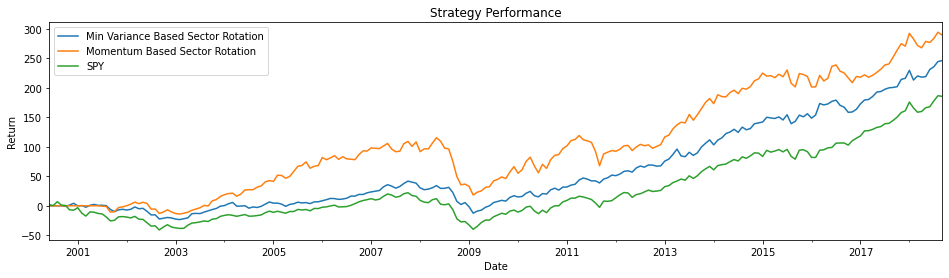

Min Variance Strategy Sharpe:  0.69
Momentum Strategy Sharpe:  0.6
SPY Sharpe:  0.47


In [4]:
min_variance_mask = (sector_df.pct_change().rolling(63).var().rank(axis=1).resample('1m').last() <= 3)
min_variance_mask = (min_variance_mask.div(min_variance_mask.sum(axis=1),axis=0)).dropna()
min_variance_returns = (sector_df.resample('1m').last().pct_change()*min_variance_mask.shift()).sum(axis=1)

momentum_mask = ((-sector_df.resample('1m').last().pct_change(11)).rank(axis=1) <= 3)
momentum_mask = (momentum_mask.div(momentum_mask.sum(axis=1),axis=0)).dropna()
momentum_returns = (sector_df.resample('1m').last().pct_change()*momentum_mask.shift(2)).sum(axis=1)

start_index = max(momentum_returns.index[0], min_variance_returns.index[0])

get_return((1+min_variance_returns)[start_index:].cumprod()).plot(figsize=(16,4),
                                                label='Min Variance Based Sector Rotation')
get_return((1+momentum_returns)[start_index:].cumprod()).plot(figsize=(16,4),
                                                label='Momentum Based Sector Rotation')
get_return((1+spy.resample('1m').last().pct_change()[start_index:]).cumprod()).plot(figsize=(16,4),
                                                label='SPY')
plt.title("Strategy Performance")
plt.ylabel("Return")
plt.legend()
plt.show()

print("Min Variance Strategy Sharpe: ", np.round(sharpe_ratio(min_variance_returns[start_index:]),2))
print("Momentum Strategy Sharpe: ", np.round(sharpe_ratio(momentum_returns[start_index:]),2))
print("SPY Sharpe: ", np.round(sharpe_ratio(spy.resample('1m').last().pct_change()[start_index:]),2))

# Short Discussion

Sector rotation seems to show some promise in terms of being able to outperform the market. Here we tested two strategies. There is the minimum variance strategy, which holds the minimum variance sector for one month and rebalances each month and the momentum strategy, which holds the top performing sector over the past year for one month and rebalances each month. We see that the minimum variance strategy produces better risk adjusted returns than the momentum based and that both strategies have reduces risk adjusted returns once the amount of diversification increases.